## Implementation of PPO with GAE using mini batches
### *heavily inpsired by OpenAI code
This code makes use of a Memory to store various values, making GAE calculation easier. Weights are not shared between actor and critic. PPO is performed using several policy updates on mini batches. 

Also please note that parameters have not been optimized. The parameters and environment are chosen for simplicity.

In [1]:
import numpy as np
import scipy.signal
from gym.spaces import Box, Discrete
import gym
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
#actor crtic module
class MLPActorCritic(nn.Module):


    def __init__(self, observation_space, action_space, 
                 hidden_sizes = (64,64), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation) #actor

        # build value function
        self.v  = MLPCritic(obs_dim, hidden_sizes, activation) #critic

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [3]:
#critic
class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.

In [4]:
#actor
class MLPCategoricalActor(nn.Module):
    
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)
    
    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and 
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

In [5]:
def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

In [6]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def discount_cumsum(x, discount):
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [22]:
class Memory:
    def __init__(self, obs_dim, act_dim, size, gamma, lambda_gae):
        # save obs, act, adv, rew, rewtg
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.rewtg_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        # define gamma and lambda
        self.gamma, self.lambda_gae = gamma, lambda_gae
        #define pointers to keep track of beginning and ending of episode (used for GAE)
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size
        
    #make functions to: store, gae and get
    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size     # make sure that there is enough room in memory
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1 # move pointer
        
    def GAE(self, last_val=0):
        # take only steps that are part of that episode
        path_slice = slice(self.path_start_idx, self.ptr) # the indices
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lambda_gae)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.rewtg_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1] # rewards to-go = discounted rewards?
        
        self.path_start_idx = self.ptr # reset pointer
    
    # gives you all data in batch
    def get(self): # get all data in memory
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0 # reset pointers
        
        # advantage normalization (usually mean&std of all parallell workers)
        self.adv_buf = (self.adv_buf - np.mean(self.adv_buf)) / np.std(self.adv_buf)
        
        # return data in seperate tensors
        data = dict(obs=self.obs_buf, 
                    act=self.act_buf, 
                    rewtg=self.rewtg_buf,
                    adv=self.adv_buf, 
                    logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}
    
    # gives you a minibatch that is based on random indeces --> wouldnt work for recurrent networks!
    def sample_batch(self, batch_size=32):
        self.ptr, self.path_start_idx = 0, 0 # reset pointers
        
        # advantage normalization (usually mean&std of all parallell workers)
        self.adv_buf = (self.adv_buf - np.mean(self.adv_buf)) / np.std(self.adv_buf)
        
        idxs = np.random.randint(0, self.max_size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     act=self.act_buf[idxs],
                     rewtg=self.rewtg_buf[idxs],
                     adv=self.adv_buf[idxs],
                     logp=self.logp_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

In [31]:
def ppo(env_fn, actor_critic=MLPActorCritic, hidden_sizes=(64,64), gamma=0.99, 
        seed=0, steps_per_epoch=200, epochs=2, pi_lr=3e-4, vf_lr=1e-3, lambda_gae=0.97, 
        max_ep_len=200, activation=nn.Tanh, train_v_iters=1, clip_ratio = 0.2, train_pi_iters = 1,
        target_kl = 0.01, batch_size = 5):
    
    # Random seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Instantiate environment
    env = env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape
    
    # Create actor-critic module
    ac = actor_critic(env.observation_space, env.action_space, hidden_sizes, activation)
    
    # Set up optimizers for policy and value function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    vf_optimizer = Adam(ac.v.parameters(), lr=vf_lr)
    
    # Set up memory
    buf = Memory(obs_dim, act_dim, steps_per_epoch, gamma, lambda_gae)
    
    #--------------------------------------------------------------------------------------------------------------
    # Set up function for computing PPO policy loss
    def compute_loss_pi(data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = ac.pi(obs, act)
        #calculate the ratio
        ratio = torch.exp(logp - logp_old)
        # PPO clip:
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        # for loss take minimum, either clipped surr or unclipped ratio surr
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        pi_info = dict(kl=approx_kl, ent=ent)
        
        return loss_pi, pi_info
    
    # Set up function for computing value loss
    def compute_loss_v(data):
        obs, rewtg = data['obs'], data['rewtg']
        return ((ac.v(obs) - rewtg)**2).mean() # (values - reward to go) MSE
    

    # Set up function for updating pi and v
    def update():
        for i in range(0, steps_per_epoch, batch_size):
            data = buf.sample_batch(batch_size)
        
            # Get loss and info values before update
            pi_l_old, pi_info_old = compute_loss_pi(data)
            pi_l_old = pi_l_old.item()
            v_l_old = compute_loss_v(data).item()

            # Train policy with multiple steps of gradient descent
            for i in range(train_pi_iters): #these iterations are not used for regular mini batches
                pi_optimizer.zero_grad()
                loss_pi, pi_info = compute_loss_pi(data)
                #instead of using minibatches, use KL early stopping
                kl = pi_info['kl']
                if kl > 1.5 * target_kl:
                    break
                loss_pi.backward()
                pi_optimizer.step()

            for i in range(train_v_iters): #these iterations are not used for regular mini batches
                # Value function learning
                vf_optimizer.zero_grad()
                loss_v = compute_loss_v(data)
                loss_v.backward()
                vf_optimizer.step()
            
        kl, ent = pi_info['kl'], pi_info_old['ent']
        return kl, ent
        
    #--------------------------------------------------------------------------------------------------------------    
    # Prepare for interaction with environment
    o = env.reset()
    ep_len = 0
    ep_rew = 0
    all_ep_rew, avg_rew, kls, ents = [], [], [], []

    # Main loop: collect experience in env and update/log each epoch
    for epoch in range(epochs):
        for t in range(steps_per_epoch):
            a, v, logp = ac.step(torch.as_tensor(o, dtype=torch.float32)) # get action based on initial obs

            next_o, r, d, _ = env.step(a) # get next obs
            ep_len += 1
            ep_rew += r
            
            # save and log
            buf.store(o, a, r, v, logp)
            
            # Update obs (critical!)
            o = next_o
            
            # keep track of where you are in episode/batch
            timeout = ep_len == max_ep_len #end of episode
            terminal = d or timeout #done or end of episode
            epoch_ended = t==steps_per_epoch-1 #end of an epoch when all steps used (when terminal continue)
            
            if terminal or epoch_ended: # only for these cases need to save next value & reset env
                #if epoch_ended and not(terminal):
                    #print('Warning: trajectory cut off by epoch at %d steps.'%ep_len, flush=True)
                # if trajectory didn't reach terminal state, bootstrap value target
                if timeout or epoch_ended:
                    _, v, _ = ac.step(torch.as_tensor(o, dtype=torch.float32)) # get next value
                    all_ep_rew.append(ep_rew)
                else:
                    v = 0 # if terminal next value is 0
                    all_ep_rew.append(ep_rew)
                    
                buf.GAE(v) # calculate advantages using these values

                o, ep_len, ep_rew = env.reset(), 0, 0 # reset the env
                
        avg_rew.append(np.mean(all_ep_rew))
        if epoch % 10 == 0:
            print("Epoch: ", epoch, "Avg rewards: ", np.mean(all_ep_rew))
        # Perform policy update, every time step
        kl, ent = update()
        kls.append(kl)
        ents.append(ent)
    return avg_rew, kls, ents

Avg rewards:  20.833333333333332
Avg rewards:  35.714285714285715
Avg rewards:  52.5
Avg rewards:  64.58333333333333
Avg rewards:  72.1830985915493
Avg rewards:  78.46153846153847
Avg rewards:  84.958217270195
Avg rewards:  89.19597989949749
Avg rewards:  94.4055944055944
Avg rewards:  99.12854030501089
Avg rewards:  101.81451612903226
Avg rewards:  105.51330798479087
Avg rewards:  108.81294964028777
Avg rewards:  111.77474402730375
Avg rewards:  114.44805194805195
Avg rewards:  116.87306501547988
Avg rewards:  119.0828402366864
Avg rewards:  120.93352192362093
Avg rewards:  122.79511533242876
Avg rewards:  124.34895833333333
Avg rewards:  125.93984962406014
Avg rewards:  127.41545893719807
Avg rewards:  128.3391405342625
Avg rewards:  128.90625
Avg rewards:  129.56989247311827
Avg rewards:  130.18672199170123
Avg rewards:  131.2877263581489
Avg rewards:  132.32421875
Avg rewards:  132.42224316682376
Avg rewards:  132.1525885558583
Avg rewards:  132.71604938271605
Avg rewards:  133.591

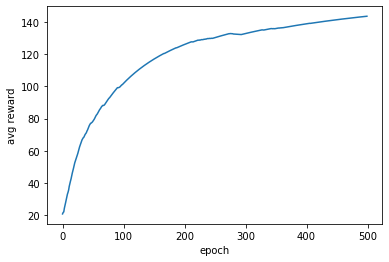

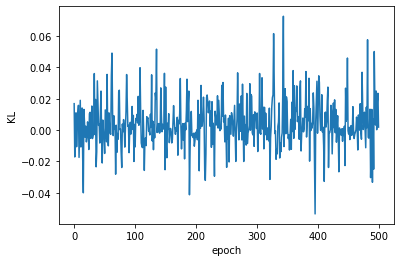

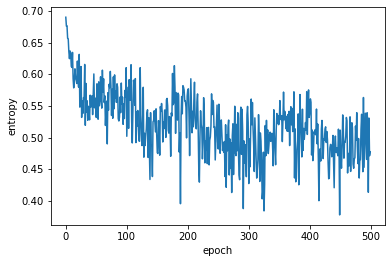

In [24]:
result, kls, ents = ppo(lambda : gym.make("CartPole-v0"), actor_critic=MLPActorCritic, hidden_sizes=(64,64), gamma=0.99, 
             seed=0, steps_per_epoch=500, epochs=500, pi_lr=3e-4, vf_lr=1e-4, lambda_gae=0.97, 
             max_ep_len=200, activation=nn.Tanh, train_v_iters = 1, clip_ratio = 0.2, train_pi_iters = 1, 
                        target_kl = 0.01, batch_size=25)

plt.plot(result)
plt.xlabel("epoch")
plt.ylabel("avg reward")
plt.show()

plt.plot(kls)
plt.xlabel("epoch")
plt.ylabel("KL")
plt.show()

plt.plot(ents)
plt.xlabel("epoch")
plt.ylabel("entropy")
plt.show()